## Dataset Creation

In [1]:
from huggingface_hub import login
login(token="")


Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [2]:
from probity.probing.datasets.templated import TemplatedDataset
from probity.probing.datasets.tokenized import TokenizedProbingDataset
from transformers import AutoTokenizer

# Create movie sentiment dataset
adjectives = {
    "positive": ["incredible", "amazing", "fantastic"],
    "negative": ["terrible", "awful", "horrible"]
}
verbs = {
    "positive": ["loved", "enjoyed", "adored"],
    "negative": ["hated", "disliked", "detested"]
}

# Create dataset using factory method
movie_dataset = TemplatedDataset.from_movie_sentiment_template(
    adjectives=adjectives,
    verbs=verbs
)

# Convert to probing dataset with automatic position finding
# and label mapping from sentiment metadata
probing_dataset = movie_dataset.to_probing_dataset(
    label_from_metadata="sentiment",
    label_map={"positive": 1, "negative": 0},
    auto_add_positions=True
)

# Convert to tokenized dataset
tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-2b")
tokenized_dataset = TokenizedProbingDataset.from_probing_dataset(
    dataset=probing_dataset,
    tokenizer=tokenizer
)



In [3]:
# Get an example from the probing dataset
probing_example = probing_dataset.examples[16]
print("Probing Dataset Example:")
print(f"Text: {probing_example.text}")
print(f"Label: {probing_example.label}")
print(f"Label Text: {probing_example.label_text}")
print(f"Character Positions: {probing_example.character_positions}")
print(f"Metadata: {probing_example.metadata}\n")

# Get an example from the tokenized dataset 
tokenized_example = tokenized_dataset.examples[16]
print("Tokenized Dataset Example:")
print(f"Text: {tokenized_example.text}")
print(f"Label: {tokenized_example.label}")
print(f"Label Text: {tokenized_example.label_text}")
print(f"Token Positions: {tokenized_example.token_positions}")
print(f"Tokens: {tokenized_example.tokens}")
print(f"Attention Mask: {tokenized_example.attention_mask}")
print(f"Metadata: {tokenized_example.metadata}")


Probing Dataset Example:
Text: I thought this movie was fantastic, I enjoyed it.
Label: 1
Label Text: positive
Character Positions: CharacterPositions(positions={'ADJ': Position(start=25, end=34), 'VERB': Position(start=38, end=45)})
Metadata: {'template': 'I thought this movie was {ADJ}, I {VERB} it.', 'variables': {'ADJ': {'sentiment': ['positive', 'positive', 'positive', 'negative', 'negative', 'negative']}, 'VERB': {'sentiment': ['positive', 'positive', 'positive', 'negative', 'negative', 'negative']}}, 'class': 'positive', 'task': 'sentiment_classification'}

Tokenized Dataset Example:
Text: I thought this movie was fantastic, I enjoyed it.
Label: 1
Label Text: positive
Token Positions: TokenPositions(positions={'ADJ': 6, 'VERB': 9})
Tokens: [2, 235285, 3421, 736, 7344, 729, 15814, 235269, 590, 13177, 665, 235265]
Attention Mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Metadata: {'template': 'I thought this movie was {ADJ}, I {VERB} it.', 'variables': {'ADJ': {'sentiment': ['positive

In [4]:
# Loop through dataset and decode token positions
for example in tokenized_dataset.examples:
    print(f"\nFull text: {example.text}")
    print("Decoded tokens at positions:")
    for pos_key in example.token_positions.keys():
        pos = example.token_positions[pos_key]
        decoded = tokenizer.decode(example.tokens[pos])
        print(f"  {pos_key}: {decoded}")



Full text: I thought this movie was terrible, I hated it.
Decoded tokens at positions:
  ADJ:  terrible
  VERB:  hated

Full text: I thought this movie was terrible, I disliked it.
Decoded tokens at positions:
  ADJ:  terrible
  VERB:  disliked

Full text: I thought this movie was terrible, I detested it.
Decoded tokens at positions:
  ADJ:  terrible
  VERB:  de

Full text: I thought this movie was awful, I hated it.
Decoded tokens at positions:
  ADJ:  awful
  VERB:  hated

Full text: I thought this movie was awful, I disliked it.
Decoded tokens at positions:
  ADJ:  awful
  VERB:  disliked

Full text: I thought this movie was awful, I detested it.
Decoded tokens at positions:
  ADJ:  awful
  VERB:  de

Full text: I thought this movie was horrible, I hated it.
Decoded tokens at positions:
  ADJ:  horrible
  VERB:  hated

Full text: I thought this movie was horrible, I disliked it.
Decoded tokens at positions:
  ADJ:  horrible
  VERB:  disliked

Full text: I thought this movie was hor

In [4]:
probing_example.text[probing_example.character_positions['ADJ'].start:probing_example.character_positions['ADJ'].end]


'horrible'

In [9]:
# Or create a custom template
from probity.probing.datasets.templated import Template, TemplateVariable

# Create variables
subject = TemplateVariable(
    name="SUBJECT",
    values=["cat", "dog"],
    metadata={"entity_type": "animal"}
)

action = TemplateVariable(
    name="ACTION",
    values=["jumped over", "ran under"],
    metadata={"movement_type": "locomotion"}
)

object_var = TemplateVariable(
    name="OBJECT",
    values=["fence", "table"],
    metadata={"object_type": "barrier"}
)

# Create template
template = Template(
    template="The {SUBJECT} {ACTION} the {OBJECT}.",
    variables={
        "SUBJECT": subject,
        "ACTION": action,
        "OBJECT": object_var
    },
    metadata={"task": "entity_movement"}
)

# Create dataset
custom_dataset = TemplatedDataset(templates=[template])

# Convert to probing dataset
probing_dataset = custom_dataset.to_probing_dataset(auto_add_positions=True)

# Convert to tokenized dataset
tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-2b")
tokenized_dataset = TokenizedProbingDataset.from_probing_dataset(
    dataset=probing_dataset,
    tokenizer=tokenizer
)

In [10]:
# Loop through dataset and decode token positions
for example in tokenized_dataset.examples:
    print(f"\nFull text: {example.text}")
    print("Decoded tokens at positions:")
    for pos_key in example.token_positions.keys():
        pos = example.token_positions[pos_key]
        decoded = tokenizer.decode(example.tokens[pos])
        print(f"  {pos_key}: {decoded}")



Full text: The cat jumped over the fence.
Decoded tokens at positions:
  ACTION:  jumped
  SUBJECT:  cat
  OBJECT:  fence

Full text: The cat jumped over the table.
Decoded tokens at positions:
  ACTION:  jumped
  SUBJECT:  cat
  OBJECT:  table

Full text: The cat ran under the fence.
Decoded tokens at positions:
  ACTION:  ran
  SUBJECT:  cat
  OBJECT:  fence

Full text: The cat ran under the table.
Decoded tokens at positions:
  ACTION:  ran
  SUBJECT:  cat
  OBJECT:  table

Full text: The dog jumped over the fence.
Decoded tokens at positions:
  ACTION:  jumped
  SUBJECT:  dog
  OBJECT:  fence

Full text: The dog jumped over the table.
Decoded tokens at positions:
  ACTION:  jumped
  SUBJECT:  dog
  OBJECT:  table

Full text: The dog ran under the fence.
Decoded tokens at positions:
  ACTION:  ran
  SUBJECT:  dog
  OBJECT:  fence

Full text: The dog ran under the table.
Decoded tokens at positions:
  ACTION:  ran
  SUBJECT:  dog
  OBJECT:  table


In [13]:
from probity.probing.datasets.templated import Template, TemplateVariable

# Create emotion-based variables
reactions = TemplateVariable(
    name="REACTION",
    values=["smiled warmly", "laughed joyfully", "frowned deeply", "scowled angrily"],
    metadata={"emotion": ["positive", "positive", "negative", "negative"]},
    class_bound=True,
    class_key="emotion"
)

responses = TemplateVariable(
    name="RESPONSE",
    values=["embraced", "welcomed", "rejected", "avoided"],
    metadata={"emotion": ["positive", "positive", "negative", "negative"]},
    class_bound=True,
    class_key="emotion"
)

# Create neutral variables for context
locations = TemplateVariable(
    name="LOCATION",
    values=["coffee shop", "library", "park", "restaurant"],
    metadata={"setting_type": "public_space"}
)

activities = TemplateVariable(
    name="ACTIVITY",
    values=["reading books", "playing chess", "sharing stories", "having lunch"],
    metadata={"activity_type": "social"}
)

# Create template with more complex structure
template = Template(
    template="When Sarah {REACTION} at the {LOCATION} while {ACTIVITY}, her friends {RESPONSE} her company.",
    variables={
        "REACTION": reactions,
        "RESPONSE": responses,
        "LOCATION": locations,
        "ACTIVITY": activities
    },
    metadata={"task": "emotion_analysis"}
)

# Create dataset
social_dataset = TemplatedDataset(templates=[template])

# Convert to probing dataset with emotion labels
probing_dataset = social_dataset.to_probing_dataset(
    label_from_metadata="emotion",
    label_map={"positive": 1, "negative": 0},
    auto_add_positions=True
)

# Convert to tokenized dataset
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-2b")
tokenized_dataset = TokenizedProbingDataset.from_probing_dataset(
    dataset=probing_dataset,
    tokenizer=tokenizer
)

# Print some random examples
import random
for example in random.sample(list(tokenized_dataset.examples), 3):
    print(f"\nFull text: {example.text}")
    print(f"Emotion class: {example.label_text}")
    print("Decoded tokens at positions:")
    for pos_key in example.token_positions.keys():
        pos = example.token_positions[pos_key]
        decoded = tokenizer.decode(example.tokens[pos])
        print(f"  {pos_key}: {decoded}")


Full text: When Sarah frowned deeply at the coffee shop while reading books, her friends avoided her company.
Emotion class: negative
Decoded tokens at positions:
  ACTIVITY:  reading
  REACTION:  frowned
  LOCATION:  coffee
  RESPONSE:  avoided

Full text: When Sarah frowned deeply at the library while sharing stories, her friends avoided her company.
Emotion class: negative
Decoded tokens at positions:
  ACTIVITY:  sharing
  REACTION:  frowned
  LOCATION:  library
  RESPONSE:  avoided

Full text: When Sarah smiled warmly at the coffee shop while playing chess, her friends embraced her company.
Emotion class: positive
Decoded tokens at positions:
  ACTIVITY:  playing
  REACTION:  smiled
  LOCATION:  coffee
  RESPONSE:  embraced


In [14]:
from transformer_lens import HookedTransformer

model = HookedTransformer.from_pretrained_no_processing("gpt2")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Loaded pretrained model gpt2 into HookedTransformer


In [ ]:
model.run_with_cache()

## Probing

### Dataset Creation


In [1]:
import torch
from probity.datasets.templated import TemplatedDataset
from probity.datasets.tokenized import TokenizedProbingDataset
from transformers import AutoTokenizer

In [2]:
# Set torch device to mps
device = "mps" if torch.backends.mps.is_available() else "cpu"

In [3]:
# Create movie sentiment dataset
adjectives = {
    "positive": ["incredible", "amazing", "fantastic", "awesome", "beautiful", "brilliant", "exceptional", "extraordinary", "fabulous", "great", "lovely", "outstanding", "remarkable", "wonderful"],
    "negative": ["terrible", "awful", "horrible", "bad", "disappointing", "disgusting", "dreadful", "horrendous", "mediocre", "miserable", "offensive", "terrible", "unpleasant", "wretched"]
}
verbs = {
    "positive": ["loved", "enjoyed", "adored"],
    "negative": ["hated", "disliked", "detested"]
}

# Create dataset using factory method
movie_dataset = TemplatedDataset.from_movie_sentiment_template(
    adjectives=adjectives,
    verbs=verbs
)

# Convert to probing dataset with automatic position finding
# and label mapping from sentiment metadata
probing_dataset = movie_dataset.to_probing_dataset(
    label_from_metadata="sentiment",
    label_map={"positive": 1, "negative": 0},
    auto_add_positions=True
)

# Convert to tokenized dataset
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
tokenized_dataset = TokenizedProbingDataset.from_probing_dataset(
    dataset=probing_dataset,
    tokenizer=tokenizer,
    padding=True,  # Add padding
    max_length=128  # Specify max length
)

# Verify the tokenization worked
example = tokenized_dataset.examples[0]
print("First example tokens:", example.tokens)
print("First example text:", example.text)

First example tokens: [40, 1807, 428, 3807, 373, 8082, 11, 314, 6151, 340, 13]
First example text: I thought this movie was incredible, I loved it.


/Users/curttigges/miniconda3/envs/sae-l/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2852: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


In [4]:
len(tokenized_dataset.examples)

84

In [5]:
# for i in range(len(tokenized_dataset.examples)):
#     # for each example, make sure there is at least one token position
#     if not tokenized_dataset.examples[i].token_positions:
#         print(f"Example {i} has no token positions: {tokenized_dataset.examples[i].text}")
#     else:
#         print(f"Example {i}: {tokenized_dataset.examples[i].text}")
    
#     for pos_key in tokenized_dataset.examples[i].token_positions.keys():
#         pos = tokenized_dataset.examples[i].token_positions[pos_key]
#         # print the de-tokenized text at the position
#         print(tokenizer.decode(tokenized_dataset.examples[i].tokens[pos]))


### Linear Probe Training

Dataset size: 84
Example text: I thought this movie was incredible, I loved it.
Token positions: TokenPositions(positions={'ADJ': 5, 'VERB': 8})
Available position keys: ['VERB', 'ADJ']

Pipeline position key: ADJ
Cache for blocks.7.hook_resid_pre is incompatible with current configuration
Cleared invalid cache directory


/Users/curttigges/Projects/probity/probity/collection/activation_store.py:121: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cache_data = torch.load(os.path.join(path, 'cach

Loaded pretrained model gpt2 into HookedTransformer
Moving model to device:  cpu
Dataset size: 84


Saving the dataset (0/1 shards):   0%|          | 0/84 [00:00<?, ? examples/s]

Examining position key: ADJ
Dataset size: 84
Dataset labels: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Dataset label texts: ['positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negativ

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/3 [00:00<?, ?it/s]

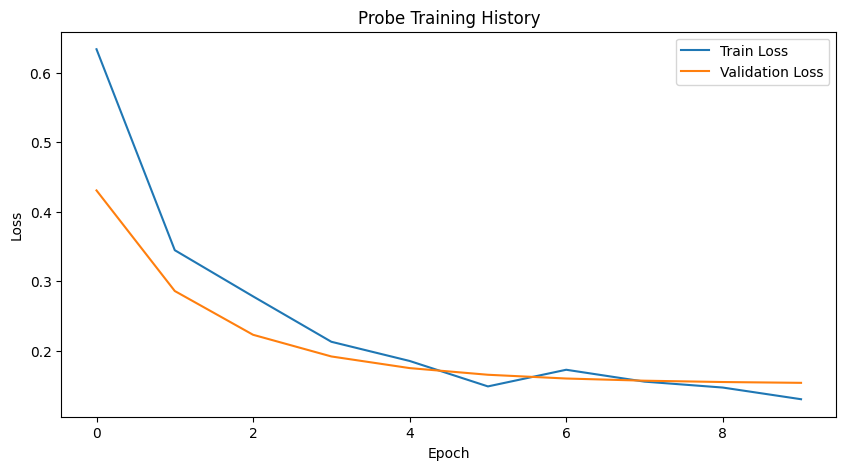

In [12]:
from probity.probes.linear_probe import LinearProbe, LinearProbeConfig
from probity.training.trainer import SupervisedProbeTrainer, SupervisedTrainerConfig
from probity.pipeline.pipeline import ProbePipeline, ProbePipelineConfig

# First, configure the probe
# GPT2-small has hidden size 768
probe_config = LinearProbeConfig(
    input_size=768,
    normalize_weights=True,  # Normalize the learned direction
    bias=False  # No bias term needed for direction finding
)

# Configure the trainer
trainer_config = SupervisedTrainerConfig(
    batch_size=32,
    learning_rate=1e-3,
    num_epochs=10,
    weight_decay=0.01,
    train_ratio=0.8,  # 80-20 train-val split
    handle_class_imbalance=True,  # Important since our classes are balanced
    show_progress=True
)

print(f"Dataset size: {len(tokenized_dataset.examples)}")

# Create pipeline configuration
pipeline_config = ProbePipelineConfig(
    dataset=tokenized_dataset,
    probe_cls=LinearProbe,
    probe_config=probe_config,
    trainer_cls=SupervisedProbeTrainer,
    trainer_config=trainer_config,
    position_key="ADJ",  # We want to probe at the adjective position
    model_name="gpt2",
    hook_points=["blocks.7.hook_resid_pre"],  # Layer 6
    cache_dir="./cache/sentiment_probe_cache"  # Cache activations for reuse
)

# Create and run pipeline
pipeline = ProbePipeline(pipeline_config)

# Add this debugging code before running the pipeline
example = tokenized_dataset.examples[0]
print(f"Example text: {example.text}")
print(f"Token positions: {example.token_positions}")
print(f"Available position keys: {list(example.token_positions.keys())}")

# Verify the position key matches what's in the dataset
print(f"\nPipeline position key: {pipeline_config.position_key}")

probe, training_history = pipeline.run()

# The probe now contains our learned sentiment direction
sentiment_direction = probe.get_direction()

# We can analyze training history
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(training_history['train_loss'], label='Train Loss')
plt.plot(training_history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Probe Training History')
plt.legend()
plt.show()

# Save the pipeline for later use
pipeline.save("./probes/sentiment_probe")



In [7]:
# To test the probe, we can get predictions for new examples
def analyze_sentiment(text: str, pipeline: ProbePipeline):
    # Tokenize new text
    tokens = tokenizer(text, return_tensors="pt")["input_ids"]
    
    # Get activations for the new text
    with torch.no_grad():
        _, cache = pipeline.collector.model.run_with_cache(
            tokens,
            names_filter=["blocks.7.hook_resid_pre"]
        )
    
    # Get the activations at target layer
    activations = cache["blocks.7.hook_resid_pre"]
    
    # Apply the probe
    logits = pipeline.probe(activations)
    probs = torch.sigmoid(logits)
    # Take the mean probability across all tokens
    return probs[0, -2].item()  # Changed this line

# Test the probe
test_text = "I thought this movie was amazing, I loved it."
sentiment_score = analyze_sentiment(test_text, pipeline)
print(f"Sentiment score (0=negative, 1=positive): {sentiment_score:.3f}")

Sentiment score (0=negative, 1=positive): 0.097


In [8]:
# Test the probe
test_text = "I thought this movie was detestable, I hated it."
sentiment_score = analyze_sentiment(test_text, pipeline)
print(f"Sentiment score (0=negative, 1=positive): {sentiment_score:.3f}")

Sentiment score (0=negative, 1=positive): 0.114


In [21]:
import torch
import json

# Load the probe weights
probe_weights = torch.load("sentiment_probe/probe.pt")['state_dict']['linear.weight'].squeeze(0)

# Convert to numpy array and then to list for JSON serialization
weights_list = probe_weights.numpy().tolist()

# Save as JSON
with open("sentiment_probe/probe.json", "w") as f:
    json.dump(weights_list, f)


/var/folders/rt/vlzhnvkj6s51xk5xshx4ldqc0000gn/T/ipykernel_13037/3101878983.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  probe_weights = torch.load("sentiment_probe/p

### Multi-probe Training


Running linear probe...
Cache for blocks.7.hook_resid_pre is incompatible with current configuration
Cleared invalid cache directory


/Users/curttigges/Projects/probity/probity/collection/activation_store.py:116: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cache_data = torch.load(os.path.join(path, 'cach

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cpu


Saving the dataset (0/1 shards):   0%|          | 0/84 [00:00<?, ? examples/s]

Examining position key: ADJ
Examining position key: ADJ


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/3 [00:00<?, ?it/s]

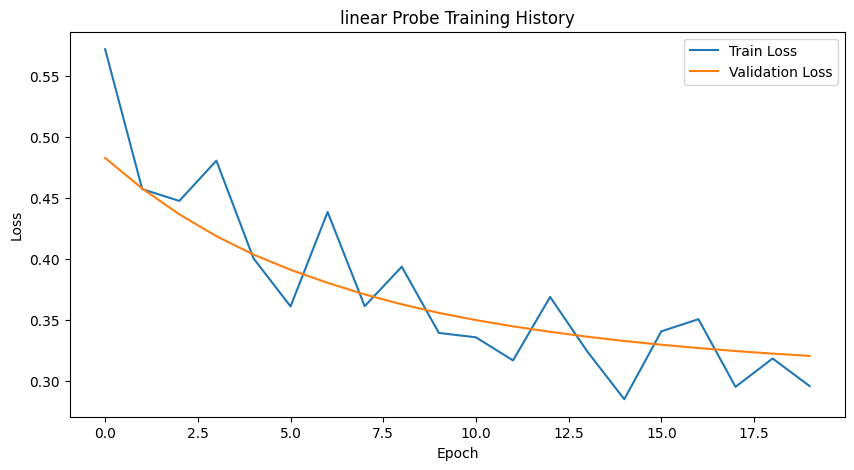

linear final training loss: 0.2960

Running logistic probe...
Cache for blocks.7.hook_resid_pre is incompatible with current configuration
Cleared invalid cache directory
Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cpu


Saving the dataset (0/1 shards):   0%|          | 0/84 [00:00<?, ? examples/s]

Examining position key: ADJ
Examining position key: ADJ


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/3 [00:00<?, ?it/s]

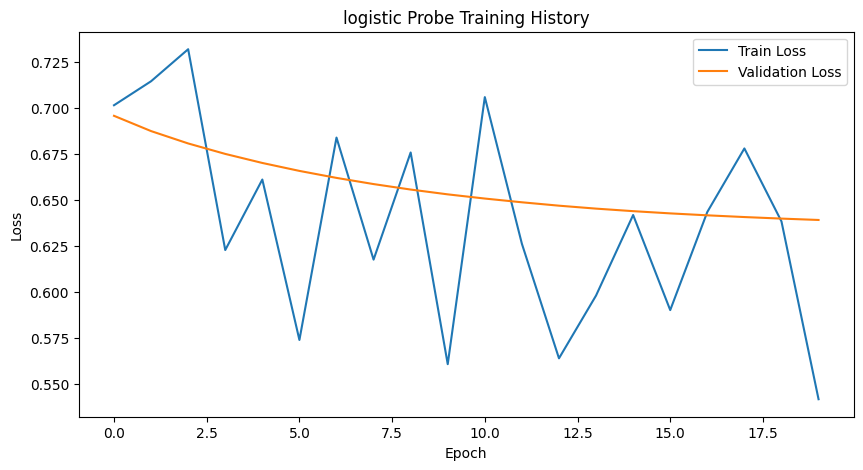

logistic final training loss: 0.5418

Running kmeans probe...
Cache for blocks.7.hook_resid_pre is incompatible with current configuration
Cleared invalid cache directory
Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cpu


Saving the dataset (0/1 shards):   0%|          | 0/84 [00:00<?, ? examples/s]

Examining position key: ADJ
Examining position key: ADJ
kmeans final training loss: 0.0000

Running pca probe...
Cache for blocks.7.hook_resid_pre is incompatible with current configuration
Cleared invalid cache directory


/Users/curttigges/Projects/probity/probity/collection/activation_store.py:116: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cache_data = torch.load(os.path.join(path, 'cach

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cpu


Saving the dataset (0/1 shards):   0%|          | 0/84 [00:00<?, ? examples/s]

Examining position key: ADJ
Examining position key: ADJ
pca final training loss: 0.0001

Running mean_diff probe...
Cache for blocks.7.hook_resid_pre is incompatible with current configuration
Cleared invalid cache directory


/Users/curttigges/Projects/probity/probity/collection/activation_store.py:116: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cache_data = torch.load(os.path.join(path, 'cach

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cpu


Saving the dataset (0/1 shards):   0%|          | 0/84 [00:00<?, ? examples/s]

Examining position key: ADJ
Examining position key: ADJ
mean_diff final training loss: 0.0000

Cosine similarities between directions:
            linear    	logistic  	kmeans    	pca       	mean_diff 
linear    	1.000     	0.004     	0.077     	0.076     	0.077     
logistic  	0.004     	1.000     	0.068     	0.063     	0.068     
kmeans    	0.077     	0.068     	1.000     	0.993     	1.000     
pca       	0.076     	0.063     	0.993     	1.000     	0.993     
mean_diff 	0.077     	0.068     	1.000     	0.993     	1.000     


In [12]:
from typing import Dict, Type
import torch
from probity.collection.collectors import TransformerLensCollector, TransformerLensConfig
from probity.probes.linear_probe import (
    LinearProbe, LogisticProbe, KMeansProbe, PCAProbe, MeanDifferenceProbe,
    LinearProbeConfig, LogisticProbeConfig, KMeansProbeConfig, PCAProbeConfig, MeanDiffProbeConfig
)
from probity.training.trainer import (
    SupervisedProbeTrainer, 
    SupervisedTrainerConfig, 
    DirectionalProbeTrainer,
    DirectionalTrainerConfig
)
from probity.pipeline.pipeline import ProbePipeline, ProbePipelineConfig
import matplotlib.pyplot as plt

# Example dataset setup (assuming you have this)
dataset = tokenized_dataset

# Model and hook point configuration
model_name = "gpt2-small"
hook_points = ["blocks.7.hook_resid_pre"]  # Examine first layer residual stream

# Function to run different probe types and compare results
def compare_probes(dataset, hidden_size: int = 768) -> Dict[str, torch.Tensor]:
    """Run all probe types and return their directions for comparison."""
    
    # Common pipeline settings
    base_config = {
        "dataset": dataset,
        "position_key": "ADJ",  # Or whatever position you're analyzing
        "model_name": model_name,
        "hook_points": hook_points,
        "cache_dir": "cache"
    }
    
    # Set up configurations for each probe type
    probe_configs = {
        "linear": (
            LinearProbe,
            LinearProbeConfig(loss_type="l1", input_size=hidden_size),
            SupervisedProbeTrainer
        ),
        "logistic": (
            LogisticProbe,
            LogisticProbeConfig(input_size=hidden_size),
            SupervisedProbeTrainer
        ),
        "kmeans": (
            KMeansProbe,
            KMeansProbeConfig(input_size=hidden_size),
            DirectionalProbeTrainer
        ),
        "pca": (
            PCAProbe,
            PCAProbeConfig(input_size=hidden_size),
            DirectionalProbeTrainer
        ),
        "mean_diff": (
            MeanDifferenceProbe,
            MeanDiffProbeConfig(input_size=hidden_size),
            DirectionalProbeTrainer
        )
    }
    
    directions = {}
    
    # Run each probe type
    for name, (probe_cls, probe_config, trainer_cls) in probe_configs.items():
        print(f"\nRunning {name} probe...")
        
        # Create pipeline configuration
        pipeline_config = ProbePipelineConfig(
            **base_config,
            probe_cls=probe_cls,
            probe_config=probe_config,
            trainer_cls=trainer_cls,
            trainer_config=SupervisedTrainerConfig(  # Use the config class directly
                batch_size=32,
                learning_rate=1e-4,
                num_epochs=20 if name in ["linear", "logistic"] else 1
            ) if trainer_cls == SupervisedProbeTrainer else DirectionalTrainerConfig(
                batch_size=32,
                learning_rate=1e-3,
                num_epochs=1
            )
        )
        
        # Run pipeline
        pipeline = ProbePipeline(pipeline_config)
        probe, history = pipeline.run()
        
        # save the probe direction to json
        probe.save_json(f"probes/{name}_direction.json")

        # if the probe is linear or logistic, plot the loss history
        if name in ["linear", "logistic"]:
            plt.figure(figsize=(10, 5))
            plt.plot(history["train_loss"], label='Train Loss')
            plt.plot(history["val_loss"], label='Validation Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title(f'{name} Probe Training History')
            plt.legend()
            plt.show()

        # Store direction
        directions[name] = probe.get_direction()
        
        # Print some metrics from history
        final_train_loss = history["train_loss"][-1]
        print(f"{name} final training loss: {final_train_loss:.4f}")
        
    return directions

# Run comparison
directions = compare_probes(dataset)

# Analyze similarity between directions
def compare_directions(directions: Dict[str, torch.Tensor]) -> None:
    """Compare the similarity of directions found by different methods."""
    names = list(directions.keys())
    print("\nCosine similarities between directions:")
    print(" " * 12 + "\t".join(f"{name:10}" for name in names))
    
    for i, name1 in enumerate(names):
        similarities = []
        for j, name2 in enumerate(names):
            dir1 = directions[name1]
            dir2 = directions[name2]
            
            # Calculate cosine similarity
            similarity = torch.nn.functional.cosine_similarity(
                dir1.unsqueeze(0), 
                dir2.unsqueeze(0)
            ).item()
            similarities.append(f"{similarity:.3f}")
            
        print(f"{name1:10}\t" + "\t".join(f"{sim:10}" for sim in similarities))

# Compare directions
compare_directions(directions)



In [ ]:
# Example of using a single probe type
def run_single_probe(
    dataset,
    probe_type: str = "logistic",
    hidden_size: int = 768
) -> torch.Tensor:
    """Run a single probe type on the dataset."""
    
    # Probe type mapping
    probe_mapping = {
        "linear": (LinearProbe, LinearProbeConfig, SupervisedProbeTrainer),
        "logistic": (LogisticProbe, LogisticProbeConfig, SupervisedProbeTrainer),
        "kmeans": (KMeansProbe, KMeansProbeConfig, DirectionalProbeTrainer),
        "pca": (PCAProbe, PCAProbeConfig, DirectionalProbeTrainer),
        "mean_diff": (MeanDifferenceProbe, MeanDiffProbeConfig, DirectionalProbeTrainer)
    }
    
    if probe_type not in probe_mapping:
        raise ValueError(f"Unknown probe type: {probe_type}")
        
    probe_cls, config_cls, trainer_cls = probe_mapping[probe_type]
    
    # Create pipeline configuration
    pipeline_config = ProbePipelineConfig(
        dataset=dataset,
        probe_cls=probe_cls,
        probe_config=config_cls(input_size=hidden_size),
        trainer_cls=trainer_cls,
        trainer_config=SupervisedTrainerConfig(  # Use the config class directly
            batch_size=32,
            learning_rate=1e-3,
            num_epochs=10 if probe_type in ["linear", "logistic"] else 1
        ) if trainer_cls == SupervisedProbeTrainer else DirectionalTrainerConfig(
            batch_size=32,
            learning_rate=1e-3,
            num_epochs=1
        ),
        position_key="ADJ",
        model_name=model_name,
        hook_points=hook_points,
        cache_dir="cache"
    )
    
    # Run pipeline
    pipeline = ProbePipeline(pipeline_config)
    probe, history = pipeline.run()

    
    return probe.get_direction()

In [7]:
# Example usage of single probe
logistic_direction = run_single_probe(dataset, "logistic")
kmeans_direction = run_single_probe(dataset, "kmeans")

AttributeError: type object 'SupervisedProbeTrainer' has no attribute 'Config'